# Evolutionary Computation Assignment 3

##### Solutions checked by solution checker

- Krzysztof Szala 144571
- Vadym Repetskyi 155610


In [1]:
from utils import TspInstance, random_solution, weighted_regret, greedy_cycle
import numpy as np
import pandas as pd
import itertools

In [2]:
def intra_route_move(tsp, solution, intra_type, steepest):
    solution = solution.copy()
    indexes = range(len(solution))
    neighborhood = [(u, v) for u in indexes for v in indexes if u != v]
    np.random.shuffle(neighborhood)

    min_cost = 0
    selected_a = selected_b = None

    for index_a, index_b in neighborhood:
        # we can draw first edge with any node, but second have to start from not node_a and not node_a+1 or node_a-1
        if intra_type != "nodes" and abs(index_a - index_b) == 1:
            continue

        a = solution[index_a]
        b = solution[index_b]

        a_prev = solution[index_a - 1]
        b_prev = solution[index_b - 1]
        if index_a - 1 < 0:
            a_prev = solution[len(solution) - 1]
        if index_b - 1 < 0:
            b_prev = solution[len(solution) - 1]

        a_next = solution[(index_a + 1) % len(solution)]
        b_next = solution[(index_b + 1) % len(solution)]
        
        a_next_next = solution[(index_a + 2) % len(solution)]
        b_next_next = solution[(index_b + 2) % len(solution)]

        if intra_type == "nodes":
            if abs(index_a - index_b) == 1: # Adjacent case
                if index_a < index_b:  # Case where a is directly before b
                    cost_change = (
                        tsp.distance_matrix[a_prev, b]
                        + tsp.distance_matrix[a, b_next]
                        - tsp.distance_matrix[a_prev, a]
                        - tsp.distance_matrix[b, b_next]
                    )
                else:  # Case where b is directly before a
                    cost_change = (
                        tsp.distance_matrix[b_prev, a]
                        + tsp.distance_matrix[b, a_next]
                        - tsp.distance_matrix[b_prev, b]
                        - tsp.distance_matrix[a, a_next]
                    )
            elif abs(index_a - index_b) == len(solution) - 1:  # Adjacent case - last and first node
                if index_a > index_b:
                    cost_change = (
                        tsp.distance_matrix[a_prev, b]
                        + tsp.distance_matrix[a, b_next]
                        - tsp.distance_matrix[a_prev, a]
                        - tsp.distance_matrix[b, b_next]
                    )
                else:
                    cost_change = (
                        tsp.distance_matrix[b_prev, a]
                        + tsp.distance_matrix[b, a_next]
                        - tsp.distance_matrix[b_prev, b]
                        - tsp.distance_matrix[a, a_next]
                    )
            else:
                # Non-adjacent case, use the general formula
                cost_change = (
                    tsp.distance_matrix[a_prev, b]
                    + tsp.distance_matrix[b, a_next]
                    + tsp.distance_matrix[b_prev, a]
                    + tsp.distance_matrix[a, b_next]
                    - tsp.distance_matrix[a_prev, a]
                    - tsp.distance_matrix[a, a_next]
                    - tsp.distance_matrix[b_prev, b]
                    - tsp.distance_matrix[b, b_next]
                )

        else:
            cost_change = (
                tsp.distance_matrix[a, b]
                + tsp.distance_matrix[a_next, b_next]
                + tsp.distance_matrix[b, a_next_next]
                + tsp.distance_matrix[a_next, b_prev]
                - tsp.distance_matrix[a, a_next]
                - tsp.distance_matrix[b, b_next]
            )

        if cost_change < min_cost:
            min_cost = cost_change
            selected_a = index_a
            selected_b = index_b

            if not steepest:
                break

    if selected_a is not None:
        if intra_type == "nodes":
            # Just swap the two nodes

            solution[selected_a], solution[selected_b] = (
                solution[selected_b],
                solution[selected_a],
            )
        else:
            # node_a stays at the same position
            # node_a+1 become node_b
            # node_b become node_a+1
            # node b+1 stays at the same position

            solution[(selected_a + 1) % len(solution)], solution[selected_b] = (
                solution[selected_b],
                solution[(selected_a + 1) % len(solution)],
            )

    return solution, min_cost


def inter_route_move(tsp, solution, steepest):
    solution = solution.copy()
    possible_unselect = set(solution)
    possible_select = set(range(tsp.size)) - possible_unselect
    neighborhood = list(itertools.product(possible_unselect, possible_select))
    np.random.shuffle(neighborhood)

    min_cost = 0
    to_unselect = to_select = None

    for test_unselect, test_select in neighborhood:
        insert_index = np.where(solution == test_unselect)[0][0]

        prev = solution[insert_index - 1]
        next = solution[(insert_index + 1) % len(solution)]

        cost_change = (
            tsp.node_costs[test_select]
            + tsp.distance_matrix[prev, test_select]
            + tsp.distance_matrix[test_select, next]
            - tsp.node_costs[test_unselect]
            - tsp.distance_matrix[prev, test_unselect]
            - tsp.distance_matrix[test_unselect, next]
        )

        if cost_change < min_cost:
            min_cost = cost_change
            to_unselect = test_unselect
            to_select = test_select

            if not steepest:
                break

    if to_unselect is not None and not steepest:
        solution[np.where(solution == to_unselect)] = to_select

    if steepest:
        return min_cost, to_unselect, to_select
    else:
        return solution, min_cost

## Local Search

### Greedy

1. Choose arbitrarily starting node and generate random/weighted(best heuristic so far) solution
2. Randomly select move from your neighbourhood
3. Iterate over all possible moves, until you find first which decrease cost (cost change would be negative) or if you would check all possible moves.
4. Repeat 2 and 3 step as long as you get a move which decrease overall solution cost, when you don't find such move return solution.

Randomly selecting solution

1. Randomly choose if inter/intra route move (if it's greedy, for steepest it doesn't matter)
2. Randomly look for next solution, remembering already visited solutions (after visiting all intra/inter moves without getting cost change decrease, check the other all possible moves within inter/intra space)

### Steepest

1. Choose arbitrarily starting node and generate random/weighted(best heuristic so far) solution
2. Check all possible moves from your neighbourhood and choose a move with the biggest decrease of cost.
3. Repeat 2 and 3 step as long as you get a move which decrease overall solution cost, when you don't find such move return solution.

In [3]:
def local_search(
    tsp: TspInstance,
    start_node: int,
    initial_solution_getter: callable,
    intra_type: str,
    steepest: bool,
):
    solution = initial_solution_getter(tsp, start_node)

    debug = False
    if debug:
        previous = list()
        counter = 0
        last_sol = None
    
    while True:
        if debug:
            counter += 1
            last_sol = solution.copy()
            previous.append((str(solution), counter))
        
        if steepest:
            cost_change_1, to_unselect, to_select = inter_route_move(tsp, solution, steepest)
            solution_2, cost_change_2 = intra_route_move(
                tsp, solution, intra_type, steepest
            )
            if cost_change_1 < cost_change_2:
                cost_change = cost_change_1
                if to_unselect is not None:
                    solution[np.where(solution == to_unselect)] = to_select
            else:
                solution, cost_change = solution_2, cost_change_2
        else:
            if np.random.rand() < 0.5:
                solution, cost_change = inter_route_move(tsp, solution, steepest)

                if cost_change == 0:
                    solution, cost_change = intra_route_move(
                        tsp, solution, intra_type, steepest
                    )
            else:
                solution, cost_change = intra_route_move(
                    tsp, solution, intra_type, steepest
                )

                if cost_change == 0:
                    solution, cost_change = inter_route_move(tsp, solution, steepest)

        if cost_change == 0:
            break

        if debug:
            if str(solution) in [x[0] for x in previous]:
                
                last_cost = tsp.get_cost(last_sol)
                current_cost = tsp.get_cost(solution)
                
                if last_cost < current_cost:
                
                    print("Previous solution")
                    print(str(previous[-1][0]))
                    list_previous = [x[1] for x in previous if x[0] == str(solution)]
                    print("Current solution")
                    print(str(solution))
                    
                    print("Last cost", last_cost)
                    print("Current cost", current_cost)
                    print("Already seen solution", "Current cost_change: ", cost_change, " in previous iteration ", list_previous)

    return solution

## Experiments


A STEEPEST NODES RANDOM


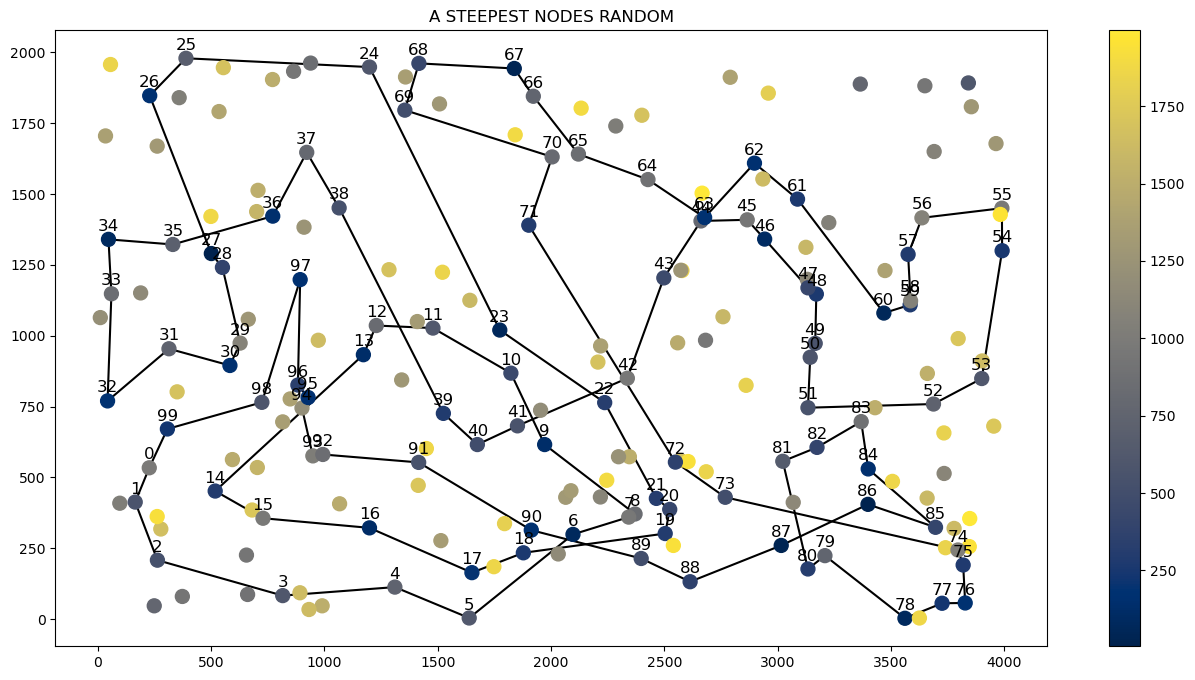

A STEEPEST NODES GREEDY


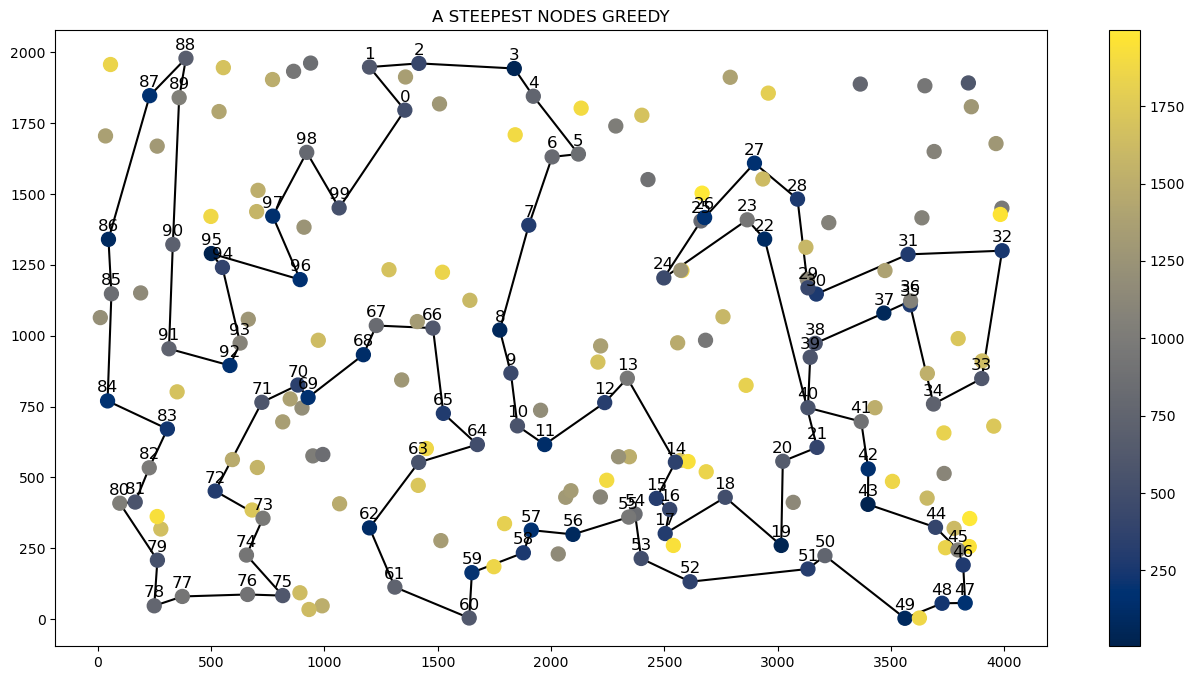

A GREEDY NODES RANDOM


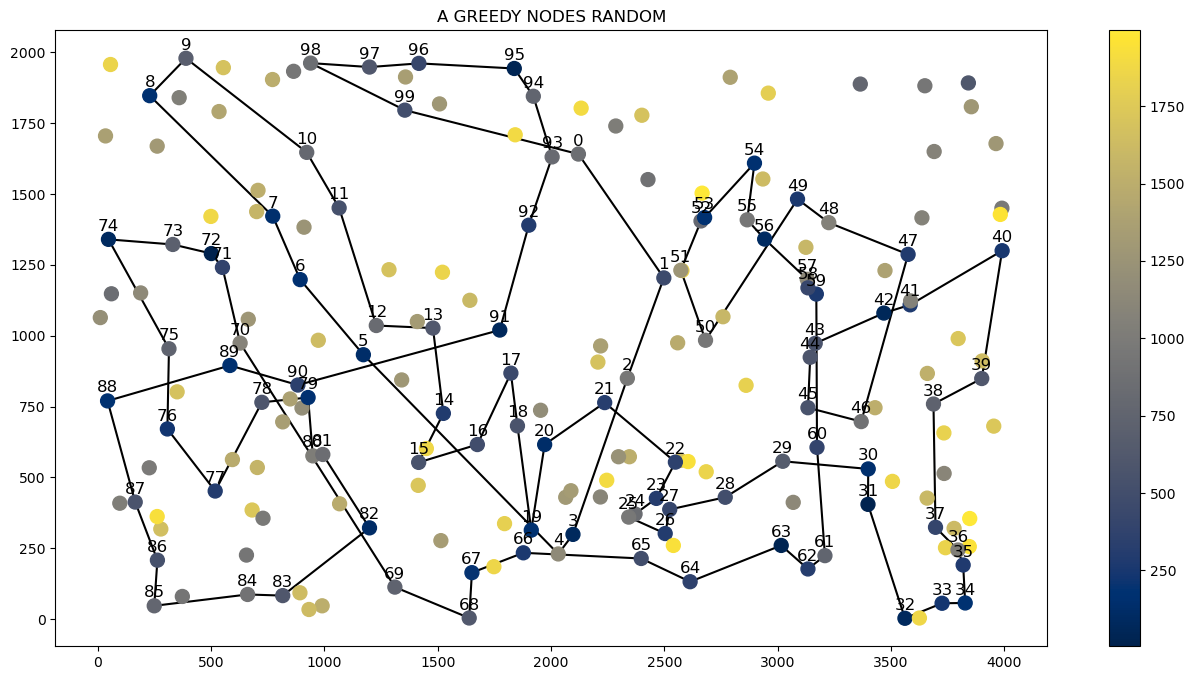

A GREEDY NODES GREEDY


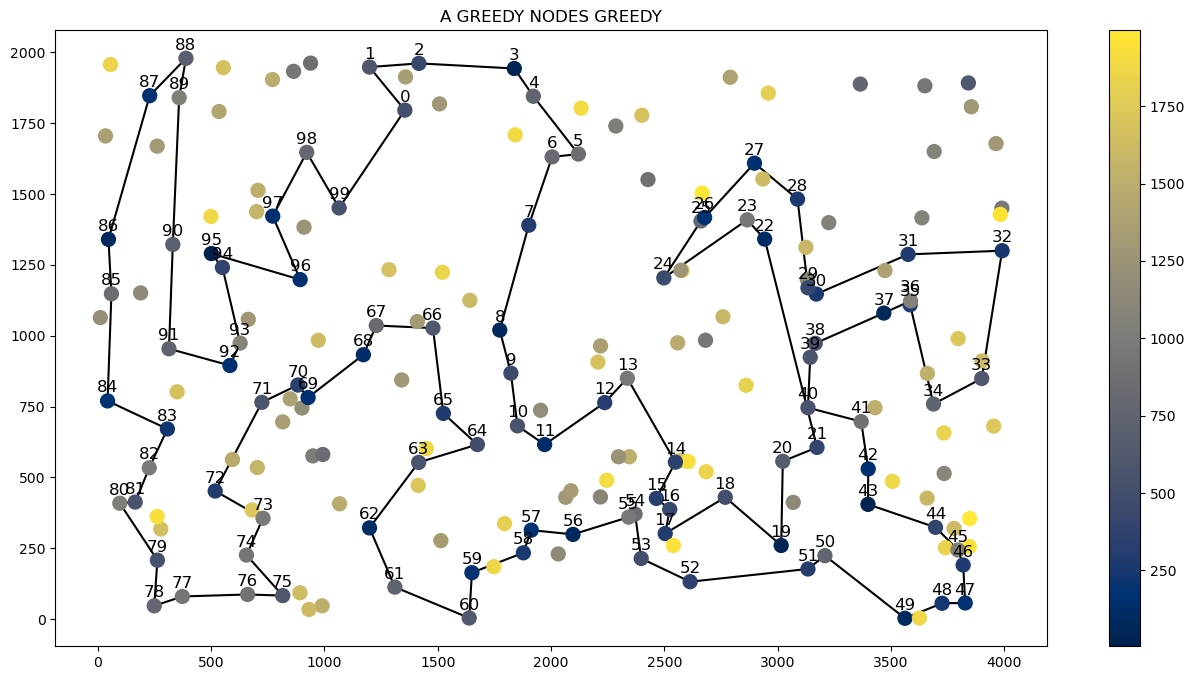

A STEEPEST EDGES RANDOM


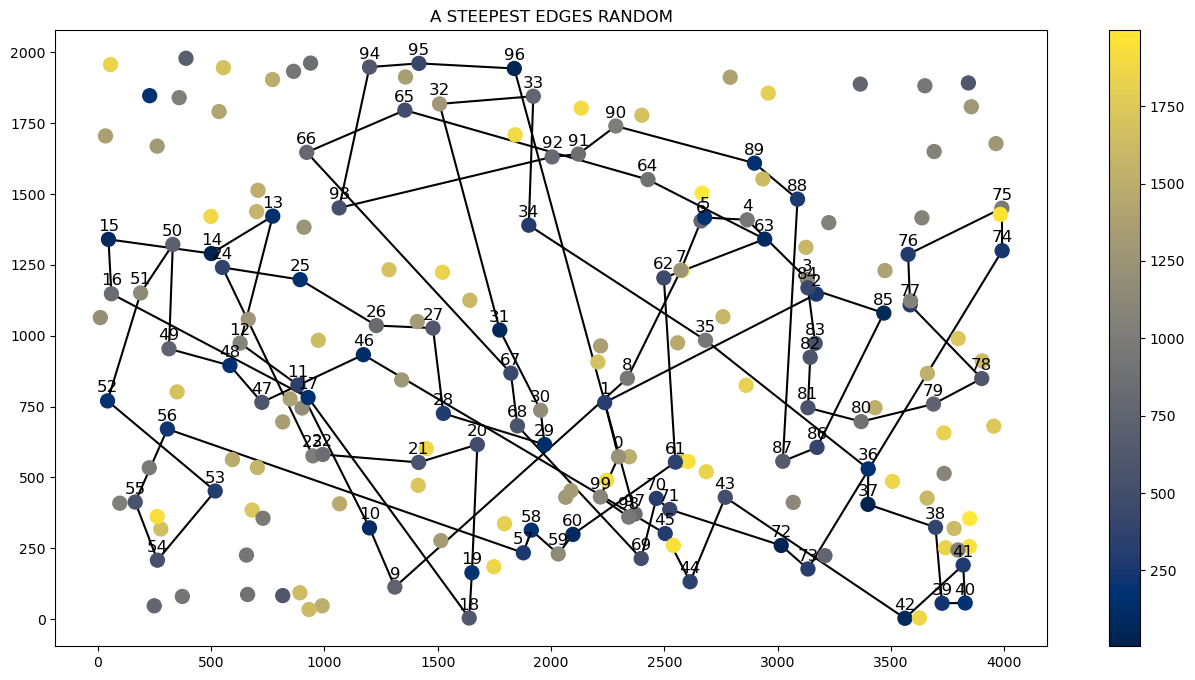

A STEEPEST EDGES GREEDY


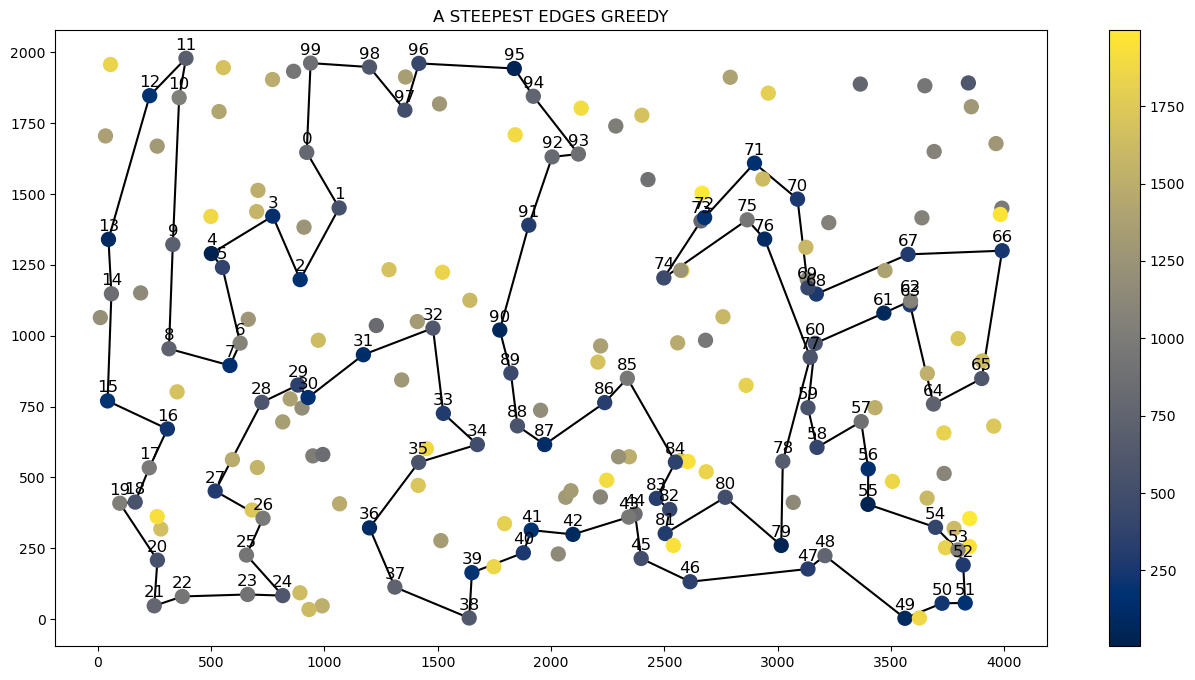

A GREEDY EDGES RANDOM


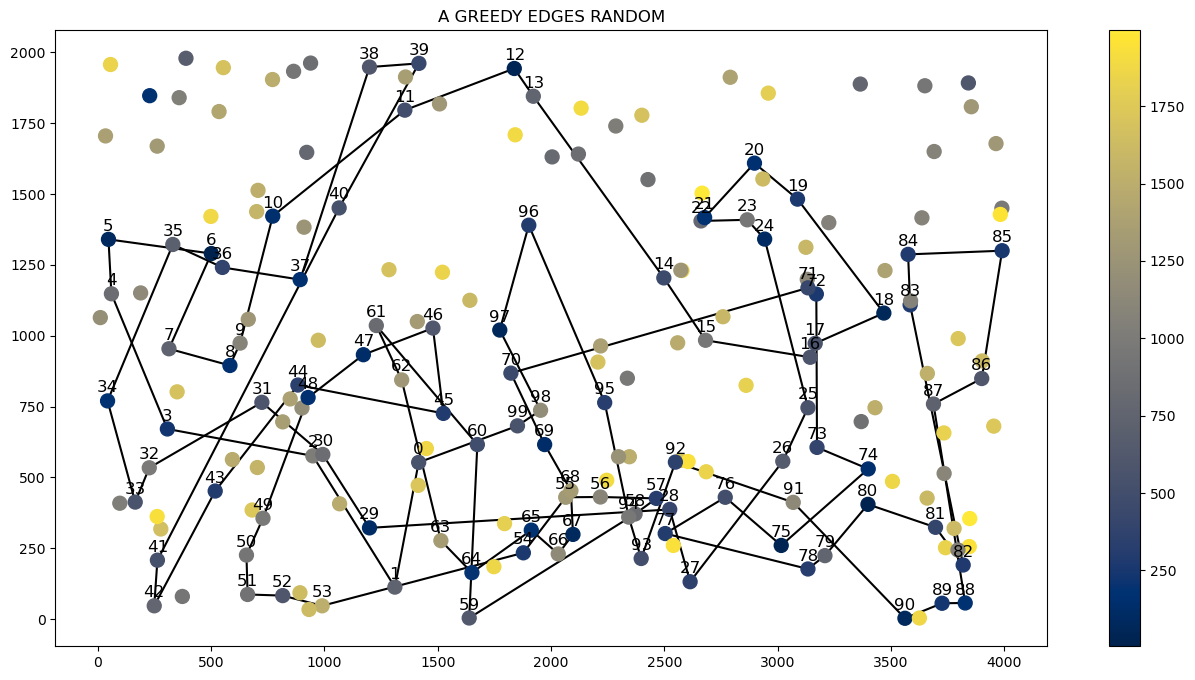

A GREEDY EDGES GREEDY


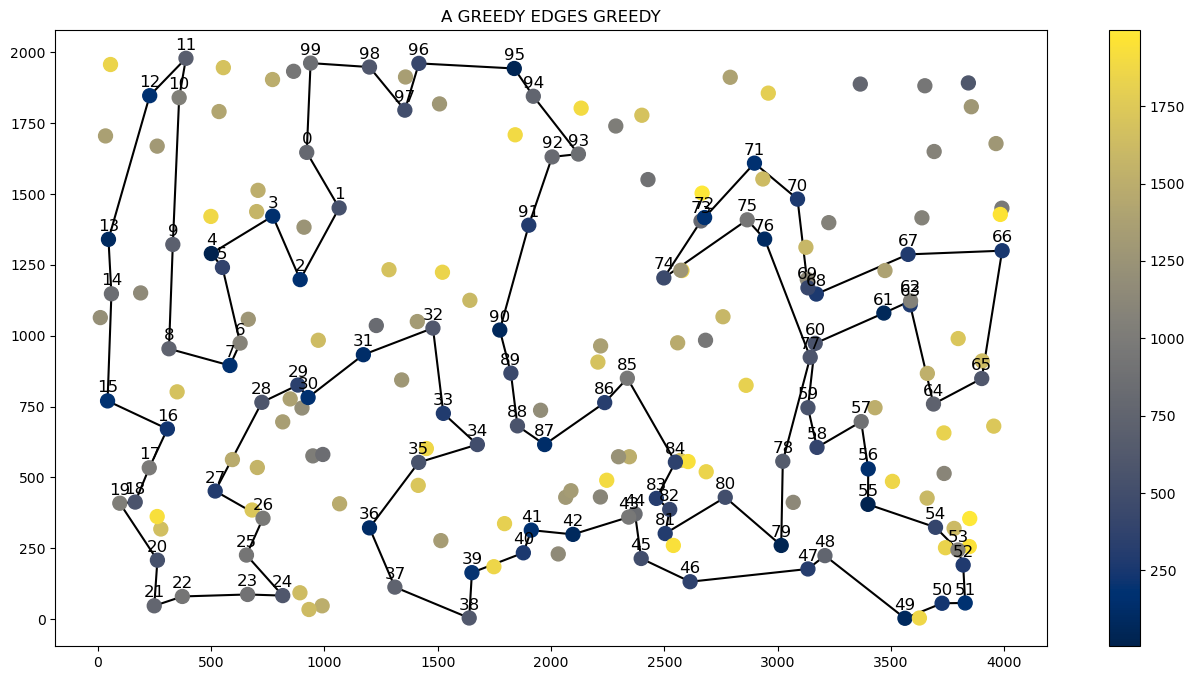

B STEEPEST NODES RANDOM


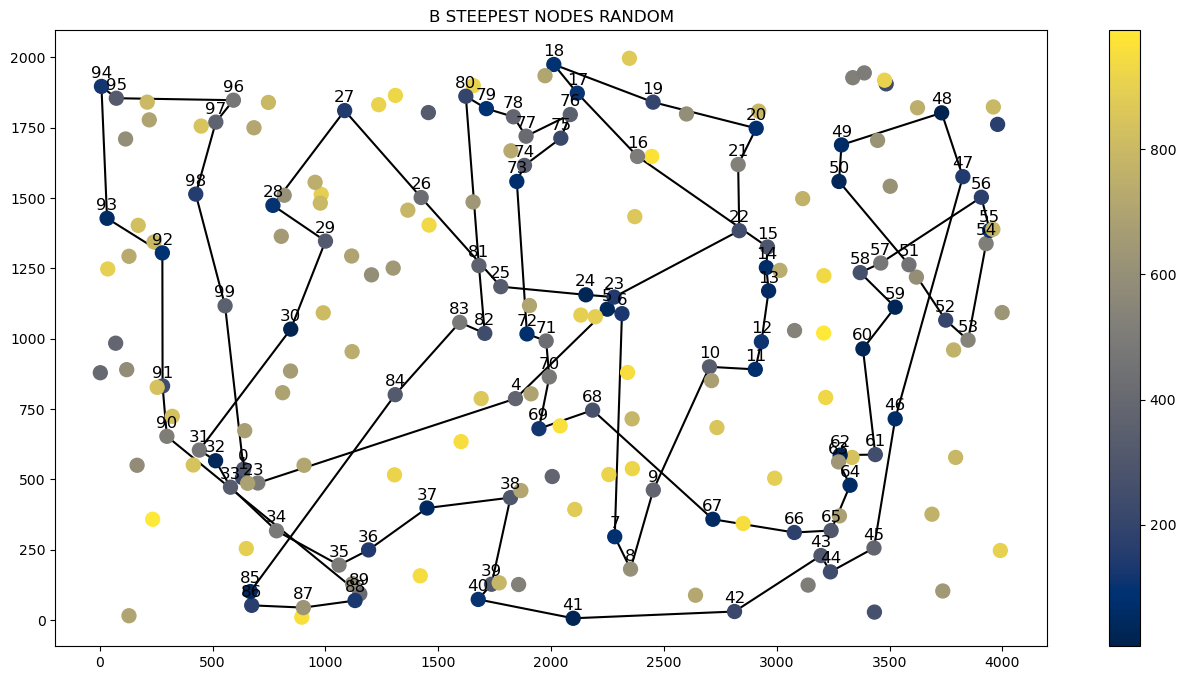

B STEEPEST NODES GREEDY


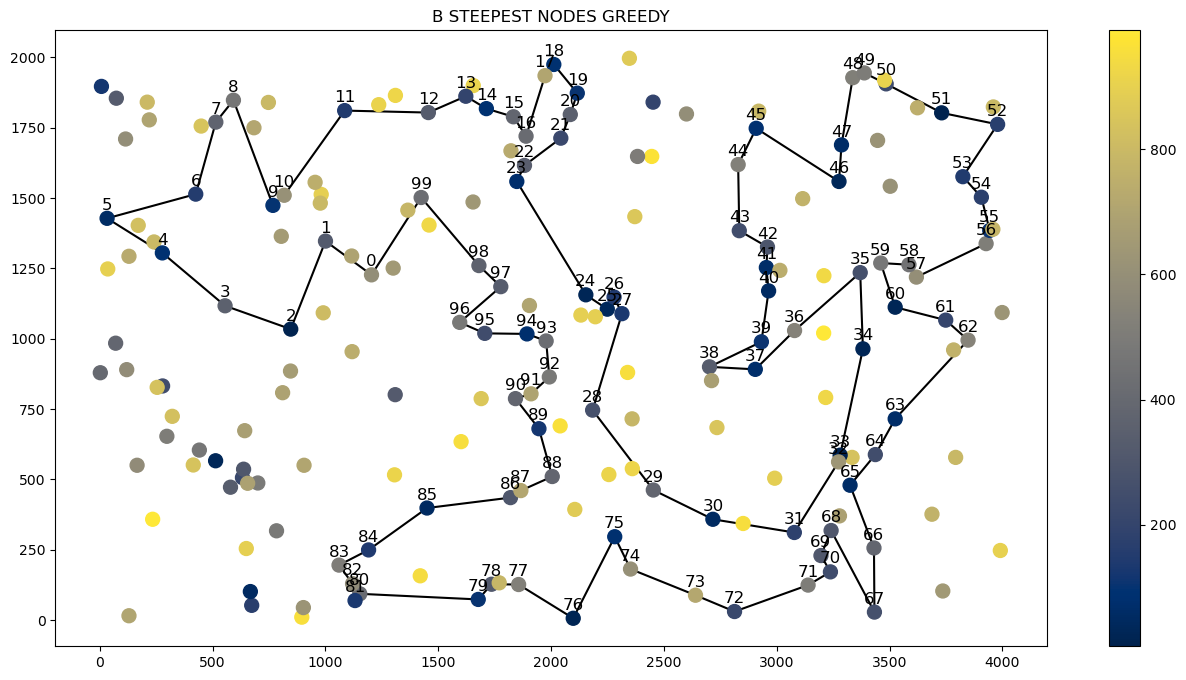

B GREEDY NODES RANDOM


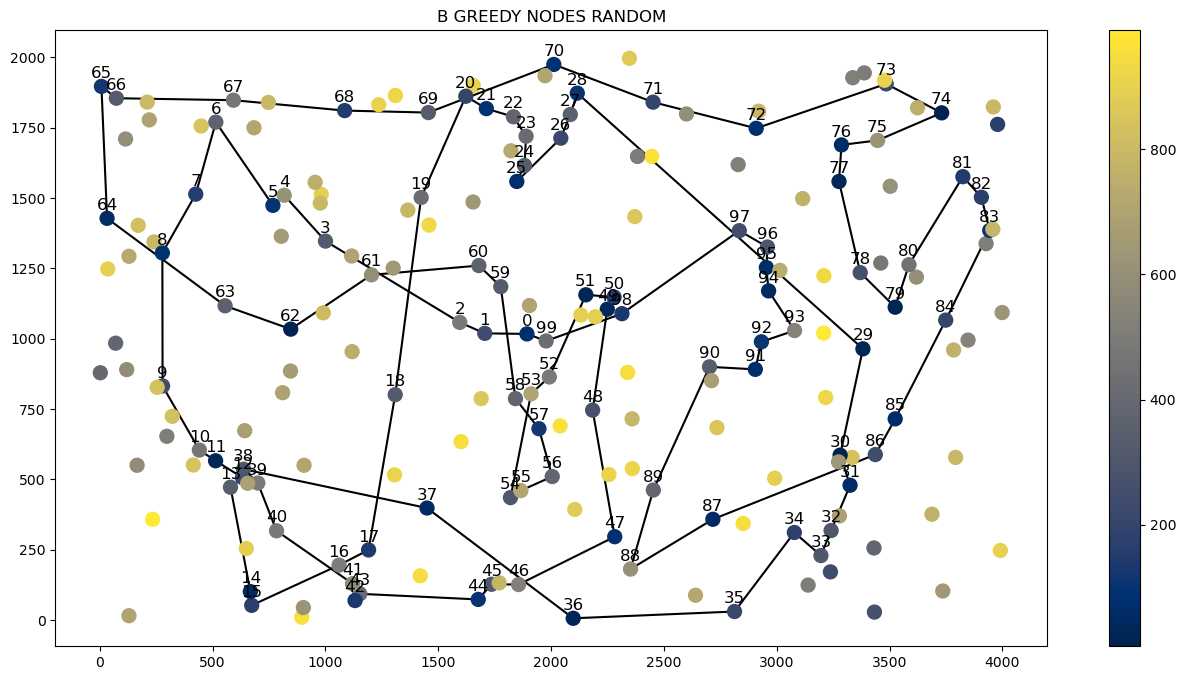

B GREEDY NODES GREEDY


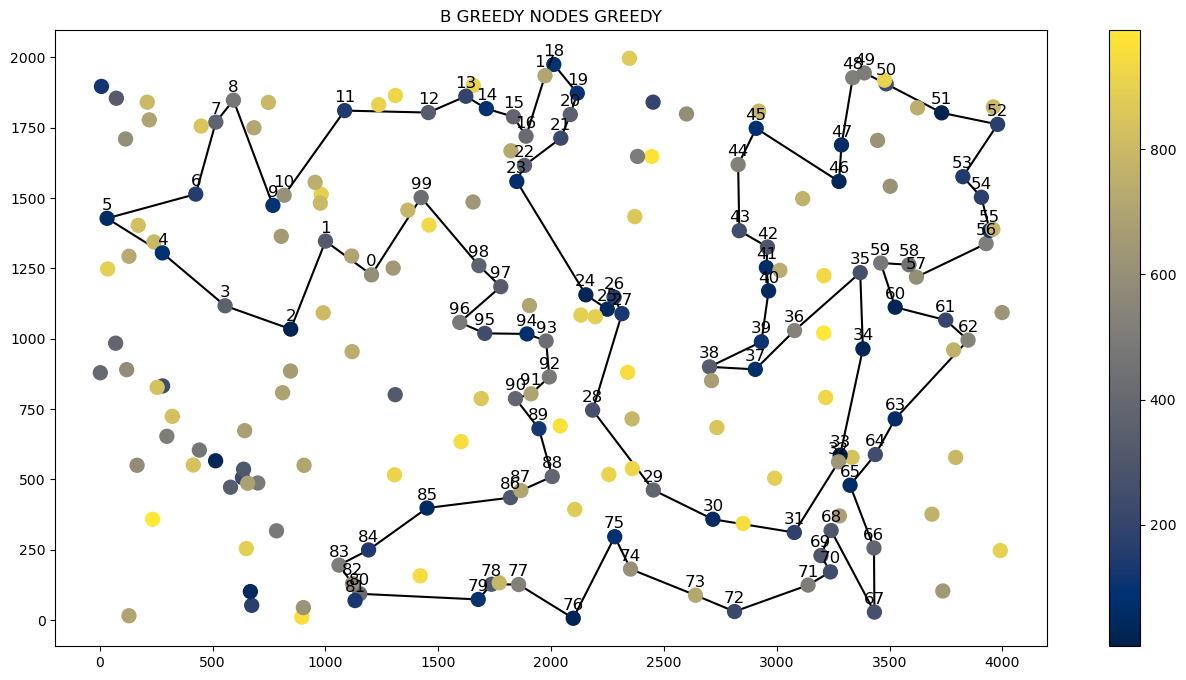

B STEEPEST EDGES RANDOM


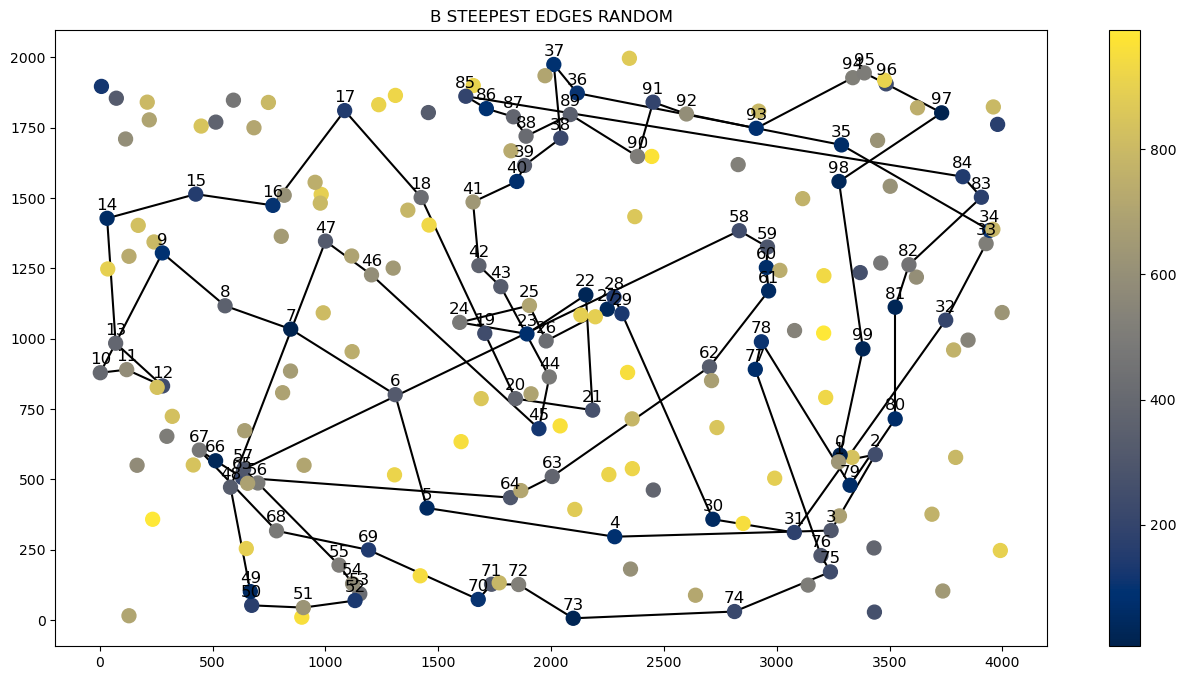

B STEEPEST EDGES GREEDY


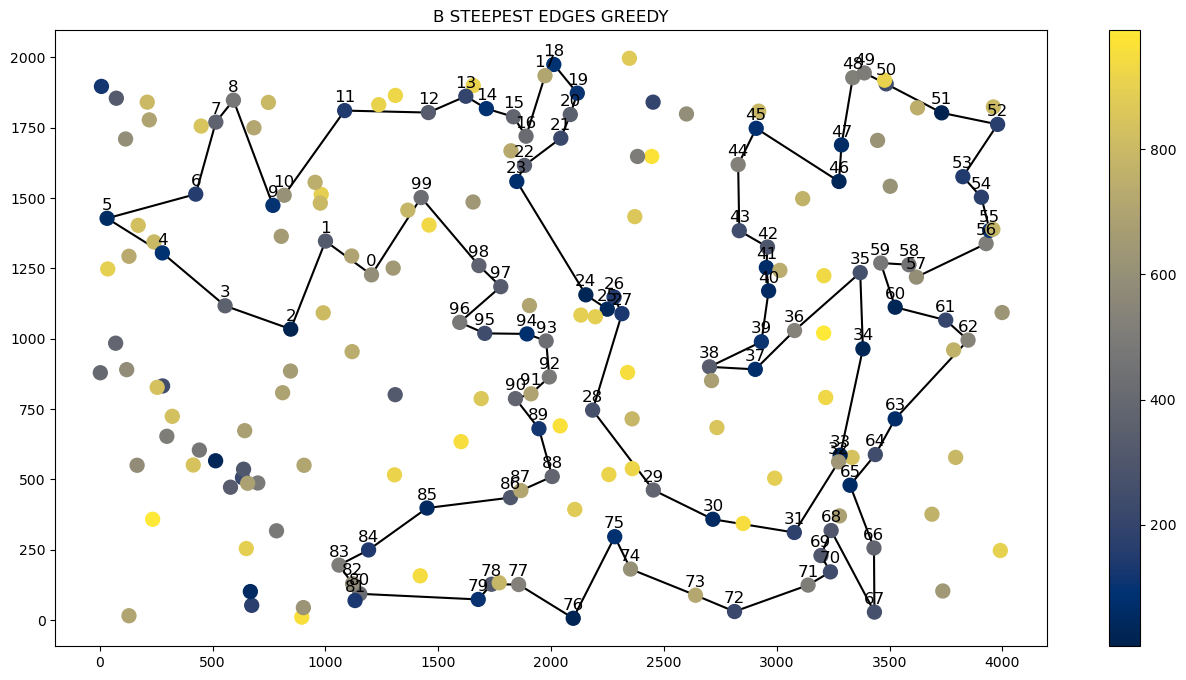

B GREEDY EDGES RANDOM


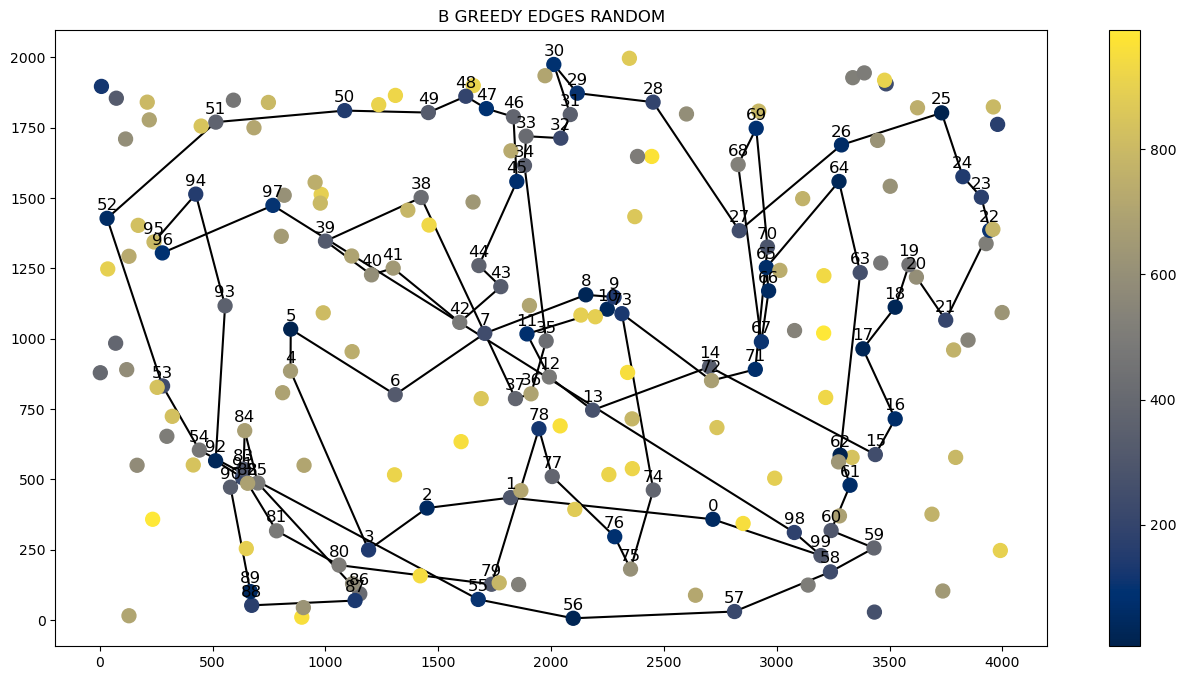

B GREEDY EDGES GREEDY


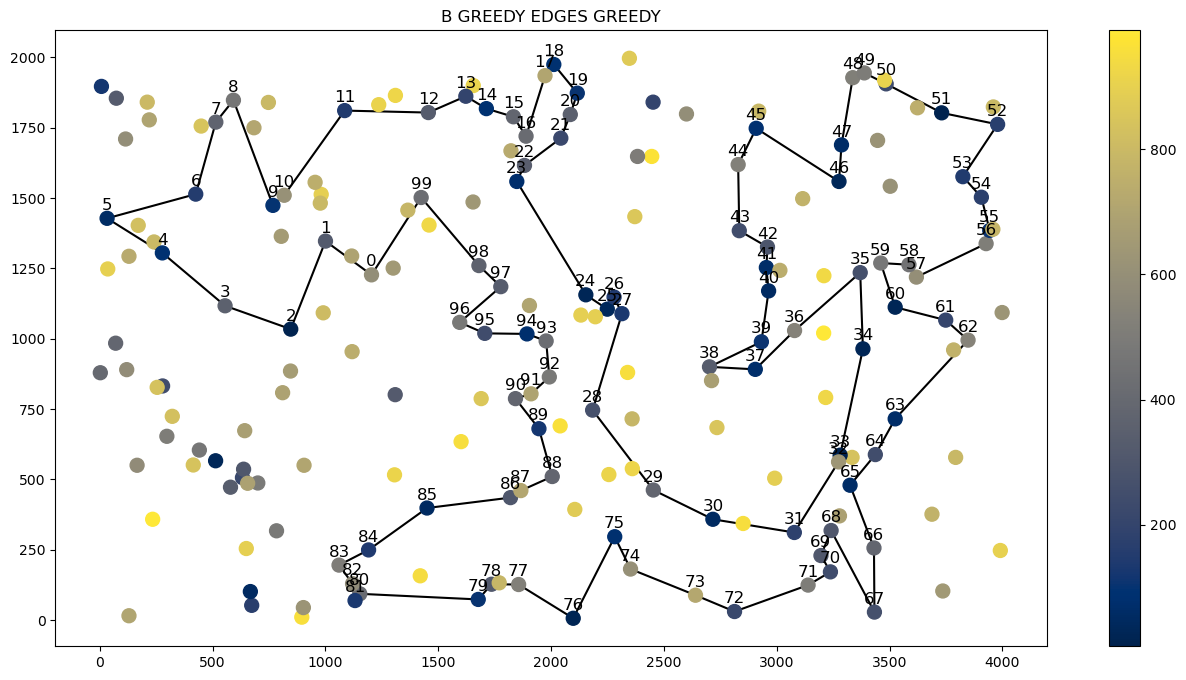

In [4]:
columns = []
experiments = []

for instance in (TspInstance("TSPA.csv"), TspInstance("TSPB.csv")):
    for intra_type in ("nodes", "edges"):
        for steepest in (True, False):
            for initial_solution_getter in (random_solution, greedy_cycle):
                column = f"{instance.file_path[3]} {"steepest" if steepest else "greedy"} {intra_type} {initial_solution_getter.__name__.split("_")[0]}".upper()
                print(column)
                columns.append(column)

                experiments.append(
                    instance.run_experiments(
                        local_search, initial_solution_getter, intra_type, steepest
                    )
                )
                instance.plot(experiments[-1][-1], column)

## Previous Methods

<div>
  <style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }

  </style>
  <table border="1" class="dataframe">
    <thead>
      <tr style="text-align: right;">
        <th></th>
        <th>Random A</th>
        <th>NN-End A</th>
        <th>NN-Any A</th>
        <th>Regret A</th>
        <th>Random B</th>
        <th>NN-End B</th>
        <th>NN-Any B</th>
        <th>Regret B</th>
      </tr>
    </thead>
    <tbody>
      <tr>
        <th>min</th>
        <td>235530.0</td>
        <td>76880.0</td>
        <td>71255.0</td>
        <td>105692.0</td>
        <td>187468.0</td>
        <td>47940.0</td>
        <td>48973.0</td>
        <td>66162.0</td>
      </tr>
      <tr>
        <th>max</th>
        <td>294275.0</td>
        <td>105198.0</td>
        <td>74220.0</td>
        <td>126951.0</td>
        <td>239215.0</td>
        <td>67185.0</td>
        <td>57348.0</td>
        <td>78406.0</td>
      </tr>
      <tr>
        <th>avg</th>
        <td>264836.7</td>
        <td>83680.24</td>
        <td>72661.445</td>
        <td>115164.15</td>
        <td>213266.78</td>
        <td>52485.63</td>
        <td>51390.06</td>
        <td>72381.19</td>
      </tr>
    </tbody>
  </table>
</div>


<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>A - greedy_cycle</th>
      <th>A - weighted_regret</th>
      <th>B - greedy_cycle</th>
      <th>B - weighted_regret</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>min_cost</th>
      <td>71488.000000</td>
      <td>110306.000000</td>
      <td>49177.000000</td>
      <td>74102.000000</td>
    </tr>
    <tr>
      <th>max_cost</th>
      <td>75528.000000</td>
      <td>173586.000000</td>
      <td>57276.000000</td>
      <td>119091.000000</td>
    </tr>
    <tr>
      <th>average_cost</th>
      <td>73018.265000</td>
      <td>133603.305000</td>
      <td>51516.000000</td>
      <td>88498.200000</td>
    </tr>
    <tr>
      <th>min_time</th>
      <td>0.396144</td>
      <td>0.411771</td>
      <td>0.392464</td>
      <td>0.411223</td>
    </tr>
    <tr>
      <th>max_time</th>
      <td>0.502558</td>
      <td>0.465876</td>
      <td>0.482928</td>
      <td>0.561436</td>
    </tr>
    <tr>
      <th>average_time</th>
      <td>0.413238</td>
      <td>0.431047</td>
      <td>0.413838</td>
      <td>0.452695</td>
    </tr>
  </tbody>
</table>
</div>

In [ ]:
results = pd.DataFrame(
    np.array(tuple(map(lambda x: x[:-1], experiments))).T,
    columns=columns,
    index=(
        "min_cost",
        "max_cost",
        "average_cost",
        "min_time",
        "max_time",
        "average_time",
    ),
)

display(results)
results.to_csv("results_exp3_cycle.csv")

In [ ]:
import pandas as pd
df = pd.read_csv("results_exp3_cycle.csv", index_col=0)

# display separately for instance A and B
df_a = df.iloc[:, :8]
df_b = df.iloc[:, 8:]

# select only without RANDOM 
df_a = df_a.loc[:, df_a.columns.str.contains("RANDOM") == False]
df_b = df_b.loc[:, df_b.columns.str.contains("RANDOM") == False]

# # sort columns by min_cost
df_a = df_a.reindex(df_a.loc["min_cost"].sort_values().index, axis=1)
df_b = df_b.reindex(df_b.loc["min_cost"].sort_values().index, axis=1)

display(df_a)
display(df_b)

## Random

<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>A GREEDY NODES RANDOM</th>
      <th>A STEEPEST NODES RANDOM</th>
      <th>A GREEDY EDGES RANDOM</th>
      <th>A STEEPEST EDGES RANDOM</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>min_cost</th>
      <td>79105.000000</td>
      <td>80397.000000</td>
      <td>91473.000000</td>
      <td>94639.000000</td>
    </tr>
    <tr>
      <th>max_cost</th>
      <td>95623.000000</td>
      <td>97593.000000</td>
      <td>113757.000000</td>
      <td>119010.000000</td>
    </tr>
    <tr>
      <th>average_cost</th>
      <td>85801.445000</td>
      <td>88029.320000</td>
      <td>102289.495000</td>
      <td>105060.995000</td>
    </tr>
    <tr>
      <th>min_time</th>
      <td>0.659213</td>
      <td>3.818357</td>
      <td>0.365875</td>
      <td>2.258811</td>
    </tr>
    <tr>
      <th>max_time</th>
      <td>2.347821</td>
      <td>10.316405</td>
      <td>1.164117</td>
      <td>4.323529</td>
    </tr>
    <tr>
      <th>average_time</th>
      <td>1.169348</td>
      <td>5.179632</td>
      <td>0.669369</td>
      <td>3.061647</td>
    </tr>
  </tbody>
</table>
</div>

<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>B GREEDY NODES RANDOM</th>
      <th>B STEEPEST NODES RANDOM</th>
      <th>B GREEDY EDGES RANDOM</th>
      <th>B STEEPEST EDGES RANDOM</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>min_cost</th>
      <td>54723.000000</td>
      <td>55012.000000</td>
      <td>61762.000000</td>
      <td>63510.000000</td>
    </tr>
    <tr>
      <th>max_cost</th>
      <td>69168.000000</td>
      <td>71294.000000</td>
      <td>83347.000000</td>
      <td>83345.000000</td>
    </tr>
    <tr>
      <th>average_cost</th>
      <td>60752.540000</td>
      <td>62971.010000</td>
      <td>71243.125000</td>
      <td>73999.835000</td>
    </tr>
    <tr>
      <th>min_time</th>
      <td>0.399585</td>
      <td>3.432420</td>
      <td>0.491979</td>
      <td>2.227556</td>
    </tr>
    <tr>
      <th>max_time</th>
      <td>1.263297</td>
      <td>6.529714</td>
      <td>1.105290</td>
      <td>3.852134</td>
    </tr>
    <tr>
      <th>average_time</th>
      <td>0.732195</td>
      <td>4.584515</td>
      <td>0.790955</td>
      <td>2.900215</td>
    </tr>
  </tbody>
</table>
</div>

## Greedy Cycle

<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>A STEEPEST NODES GREEDY</th>
      <th>A GREEDY NODES GREEDY</th>
      <th>A STEEPEST EDGES GREEDY</th>
      <th>A GREEDY EDGES GREEDY</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>min_cost</th>
      <td>71285.000000</td>
      <td>71285.000000</td>
      <td>71328.000000</td>
      <td>71328.000000</td>
    </tr>
    <tr>
      <th>max_cost</th>
      <td>73863.000000</td>
      <td>73863.000000</td>
      <td>74197.000000</td>
      <td>74197.000000</td>
    </tr>
    <tr>
      <th>average_cost</th>
      <td>72334.620000</td>
      <td>72333.595000</td>
      <td>72397.980000</td>
      <td>72401.340000</td>
    </tr>
    <tr>
      <th>min_time</th>
      <td>0.317369</td>
      <td>0.303158</td>
      <td>0.303239</td>
      <td>0.308158</td>
    </tr>
    <tr>
      <th>max_time</th>
      <td>0.746422</td>
      <td>0.557146</td>
      <td>0.976665</td>
      <td>0.543812</td>
    </tr>
    <tr>
      <th>average_time</th>
      <td>0.468273</td>
      <td>0.395152</td>
      <td>0.415126</td>
      <td>0.391035</td>
    </tr>
  </tbody>
</table>
</div>

<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>B STEEPEST NODES GREEDY</th>
      <th>B GREEDY NODES GREEDY</th>
      <th>B STEEPEST EDGES GREEDY</th>
      <th>B GREEDY EDGES GREEDY</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>min_cost</th>
      <td>48305.000000</td>
      <td>48305.000000</td>
      <td>48305.000000</td>
      <td>48305.000000</td>
    </tr>
    <tr>
      <th>max_cost</th>
      <td>56856.000000</td>
      <td>56856.000000</td>
      <td>57018.000000</td>
      <td>57018.000000</td>
    </tr>
    <tr>
      <th>average_cost</th>
      <td>50838.195000</td>
      <td>50851.055000</td>
      <td>50911.045000</td>
      <td>50903.075000</td>
    </tr>
    <tr>
      <th>min_time</th>
      <td>0.431397</td>
      <td>0.317677</td>
      <td>0.375504</td>
      <td>0.324277</td>
    </tr>
    <tr>
      <th>max_time</th>
      <td>0.889067</td>
      <td>0.499671</td>
      <td>0.763459</td>
      <td>0.481033</td>
    </tr>
    <tr>
      <th>average_time</th>
      <td>0.564736</td>
      <td>0.397553</td>
      <td>0.495086</td>
      <td>0.389223</td>
    </tr>
  </tbody>
</table>
</div>

# Conlusions:
- Comparing new methods 
    - All methods which started from greedy-cycle solution had better results than random starting solution
    - Methods not using random starting solutions were far faster than using heuristic
    - Intra-nodes changes worked better, all methods using nodes instead of intra-edges had better objective function value
    - For random starting solution greedy method worked better than steepest, giving us lower cost value, but for greedy cycle, it seems that it didn't have any significant impact.
    - As expected, steepest method was slower than greedy
    - Differences in time for intra nodes/edges aren't correlated in any way
- Comparing with meethods from the previous laboratories
    - Results of new methods suprisingly were only slightly better than previous best solutions, our greedy/steepest probably made only few moves before stop